In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score,RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# pytorch and pytorch lightning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision 
from torchvision import datasets
import torchvision.transforms as transforms
!pip install torchsummary
from torchsummary import summary
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# others
import os
from tqdm import tqdm_notebook as tqdm
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
# print("Number of workers:", NUM_WORKERS)

Device: cpu


In [3]:
# global constants
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 3

In [4]:
# define image transformation for detection of dataset shift
def images_transforms():
    data_transformation = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
    return data_transformation

In [5]:
# dataset path
train_path='../input/covid19-image-dataset/Covid19-dataset/train'
val_path='../input/covid19-image-dataset/Covid19-dataset/test/'
deploy_path='../input/covid19radiographydatabaseedited/COVID-19_Radiography_Dataset'

# import data
trainset=datasets.ImageFolder(train_path,transform=images_transforms())
valset=datasets.ImageFolder(val_path,transform=images_transforms())
deployset=datasets.ImageFolder(deploy_path,transform=images_transforms())

# reduce size of deployment data (for computational time and memory)
n_deployment = 800
deploy_idx = np.random.choice(len(deployset.targets), size=n_deployment, replace=False)
deployset = Subset(deployset, deploy_idx)

print("Training set size: {}\nValidation set size: {}\nDeployment set size: {}".format(len(trainset.targets),len(valset.targets),n_deployment))
print(trainset.class_to_idx)

Training set size: 251
Validation set size: 66
Deployment set size: 800
{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [6]:
'''
def imshow(img):
    plt.figure(figsize=(20, 20))
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
    img = invTrans(img) # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
'''

'\ndef imshow(img):\n    plt.figure(figsize=(20, 20))\n    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],\n                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),\n                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],\n                                                     std = [ 1., 1., 1. ]),\n                               ])\n    img = invTrans(img) # unnormalize\n    npimg = img.numpy()\n    plt.imshow(np.transpose(npimg, (1, 2, 0)))\n    plt.show()\n'

In [7]:
'''
# Training data visualization
train_loader = DataLoader(trainset,batch_size=16,shuffle=True,num_workers=2)
train_examples = iter(train_loader)
images,labels = train_examples.next()
print(images.shape)
imshow(torchvision.utils.make_grid(images))
'''

'\n# Training data visualization\ntrain_loader = DataLoader(trainset,batch_size=16,shuffle=True,num_workers=2)\ntrain_examples = iter(train_loader)\nimages,labels = train_examples.next()\nprint(images.shape)\nimshow(torchvision.utils.make_grid(images))\n'

In [8]:
'''
# Deployment data visualization
deploy_loader = DataLoader(deployset,batch_size=16,shuffle=True,num_workers=2)
deploy_examples = iter(deploy_loader)
images,labels = deploy_examples.next()
print(images.shape)
imshow(torchvision.utils.make_grid(images))
'''

'\n# Deployment data visualization\ndeploy_loader = DataLoader(deployset,batch_size=16,shuffle=True,num_workers=2)\ndeploy_examples = iter(deploy_loader)\nimages,labels = deploy_examples.next()\nprint(images.shape)\nimshow(torchvision.utils.make_grid(images))\n'

# Histograms on the distribution of images

In [9]:
BATCH_SIZE = 16
train_loader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)
train_values = torch.zeros(len(trainset.targets), NUM_CLASSES, *IMAGE_SIZE)

for i, (images, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):
    train_values[BATCH_SIZE*i:BATCH_SIZE*i+images.shape[0],:,:,:] = images

print(train_values.shape)
train_values = torch.mean(train_values, dim=1).reshape(-1)
print(train_values.shape)

  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([251, 3, 224, 224])
torch.Size([12594176])


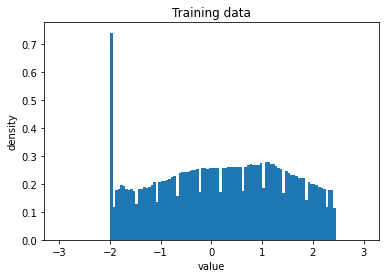

In [10]:
plt.hist(train_values, bins=120, range=(-3,3), density=True)
plt.title("Training data")
plt.xlabel("value")
plt.ylabel("density")
plt.show()

In [11]:
val_loader = DataLoader(valset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)
val_values = torch.zeros(len(valset.targets), NUM_CLASSES, *IMAGE_SIZE)

for i, (images, labels) in enumerate(tqdm(val_loader, total=int(len(val_loader)))):
    val_values[BATCH_SIZE*i:BATCH_SIZE*i+images.shape[0],:,:,:] = images

print(val_values.shape)
val_values = torch.mean(val_values, dim=1).reshape(-1)
print(val_values.shape)

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([66, 3, 224, 224])
torch.Size([3311616])


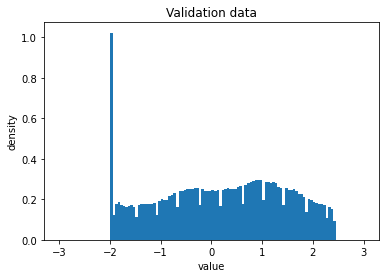

In [12]:
plt.hist(val_values, bins=120, range=(-3,3), density=True)
plt.title("Validation data")
plt.xlabel("value")
plt.ylabel("density")
plt.show()

In [13]:
deploy_loader = DataLoader(deployset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)
deploy_values = torch.zeros(BATCH_SIZE*10, NUM_CLASSES, *IMAGE_SIZE)

for i, (images, labels) in enumerate(tqdm(deploy_loader, total=int(len(deploy_loader)))):
    deploy_values[BATCH_SIZE*i:BATCH_SIZE*i+images.shape[0],:,:,:] = images
    if i == 9:
        break

print(deploy_values.shape)
deploy_values = torch.mean(deploy_values, dim=1).reshape(-1)
print(deploy_values.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([160, 3, 224, 224])
torch.Size([8028160])


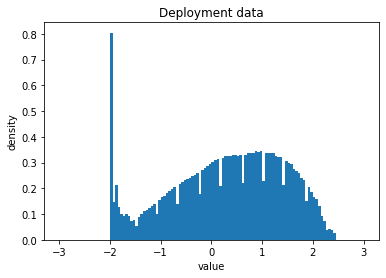

In [14]:
plt.hist(deploy_values, bins=120, range=(-3,3), density=True)
plt.title("Deployment data")
plt.xlabel("value")
plt.ylabel("density")
plt.show()

# KS divergence

In [15]:
from scipy.stats import ks_2samp
stat_detect, p_detect = ks_2samp(train_values, deploy_values)
stat_control, p_control = ks_2samp(train_values, val_values)

In [16]:
print("Detection: KS value is {:.3f} with p-value {}".format(stat_detect, p_detect))
print("Control: KS value is {:.3f} with p-value {}".format(stat_control, p_control))

Detection: KS value is 0.073 with p-value 0.0
Control: KS value is 0.015 with p-value 0.0


# Investigation on the classes of dataset A / B

In [17]:
train_loader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)
train_values = torch.zeros(len(trainset.targets), NUM_CLASSES, *IMAGE_SIZE)
train_labels = torch.zeros(len(trainset.targets))

for i, (images, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):
    train_values[BATCH_SIZE*i:BATCH_SIZE*i+images.shape[0],:,:,:] = images
    train_labels[BATCH_SIZE*i:BATCH_SIZE*i+images.shape[0]] = labels

print(train_values.shape)

  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([251, 3, 224, 224])


In [18]:
val_loader = DataLoader(valset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)
val_values = torch.zeros(len(valset.targets), NUM_CLASSES, *IMAGE_SIZE)
val_labels = torch.zeros(len(valset.targets))

for i, (images, labels) in enumerate(tqdm(val_loader, total=int(len(val_loader)))):
    val_values[BATCH_SIZE*i:BATCH_SIZE*i+images.shape[0],:,:,:] = images
    val_labels[BATCH_SIZE*i:BATCH_SIZE*i+images.shape[0]] = labels

print(val_values.shape)

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([66, 3, 224, 224])


torch.Size([137, 3, 224, 224])
Detection for data "COVID": KS value is 0.028 with p-value 0.0
torch.Size([90, 3, 224, 224])
Detection for data "Normal": KS value is 0.116 with p-value 0.0
torch.Size([90, 3, 224, 224])
Detection for data "Viral Pneumonia": KS value is 0.128 with p-value 0.0


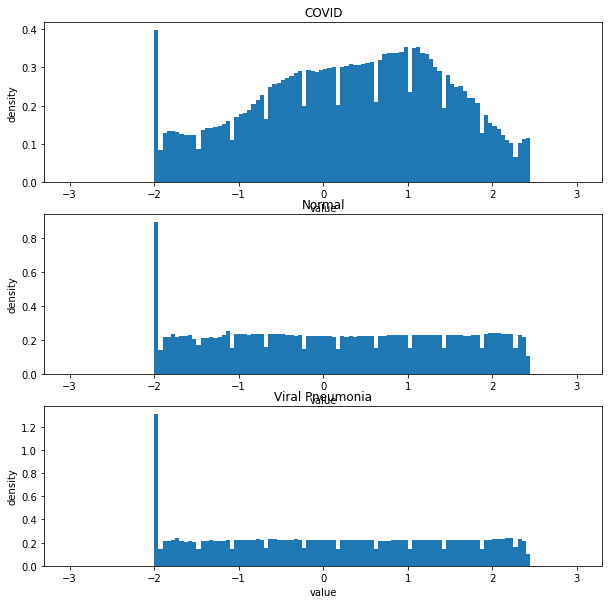

In [19]:
values_list = []
plt.figure(figsize=(10, 10))

for c in range(NUM_CLASSES):
    plt.subplot(311+c)
    train_values_by_class = train_values[np.where(train_labels==c)[0],:,:,:]
    val_values_by_class = val_values[np.where(val_labels==c)[0],:,:,:]
    values = torch.cat((train_values_by_class, val_values_by_class), dim=0)
    print(values.shape)
    values = torch.mean(values, dim=1).reshape(-1)
    stat_detect, p_detect = ks_2samp(values, deploy_values)
    values_list.append(values)
    plt.hist(values, bins=120, range=(-3,3), density=True)
    if c == 0:
        title = "COVID"
    elif c == 1:
        title = "Normal"
    else:
        title = "Viral Pneumonia"
    print("Detection for data \"{}\": KS value is {:.3f} with p-value {}".format(title, stat_detect, p_detect))
    plt.title(title)
    plt.xlabel("value")
    plt.ylabel("density")

plt.subplots_adjust(hspace = 0.2)
plt.show()

In [20]:
stat_detect_01, p_detect_01 = ks_2samp(values_list[0], values_list[1])
print("KS value between COVID/Normal is {:.3f} with p-value {}".format(stat_detect_01, p_detect_01))
stat_detect_02, p_detect_02 = ks_2samp(values_list[0], values_list[2])
print("KS value between COVID/Viral Pneumonia is {:.3f} with p-value {}".format(stat_detect_02, p_detect_02))
stat_detect_12, p_detect_12 = ks_2samp(values_list[1], values_list[2])
print("KS value between Normal/Viral Pneumonia is {:.3f} with p-value {}".format(stat_detect_12, p_detect_12))

KS value between COVID/Normal is 0.112 with p-value 0.0
KS value between COVID/Viral Pneumonia is 0.125 with p-value 0.0
KS value between Normal/Viral Pneumonia is 0.021 with p-value 0.0
